In [2]:
import tensorflow as tf
import numpy as np
import cv2
from modules.test import test
from tensorflow import keras

from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

    

2023-06-30 20:30:55.680160: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-30 20:30:55.723127: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)


    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [4]:
test_image_list, test_image_label, test_image_path = test.load_test("/app/data/User/image/test", [512, 512, 1], weld_type = True, preprocess = None)

(1, 512, 512, 1)


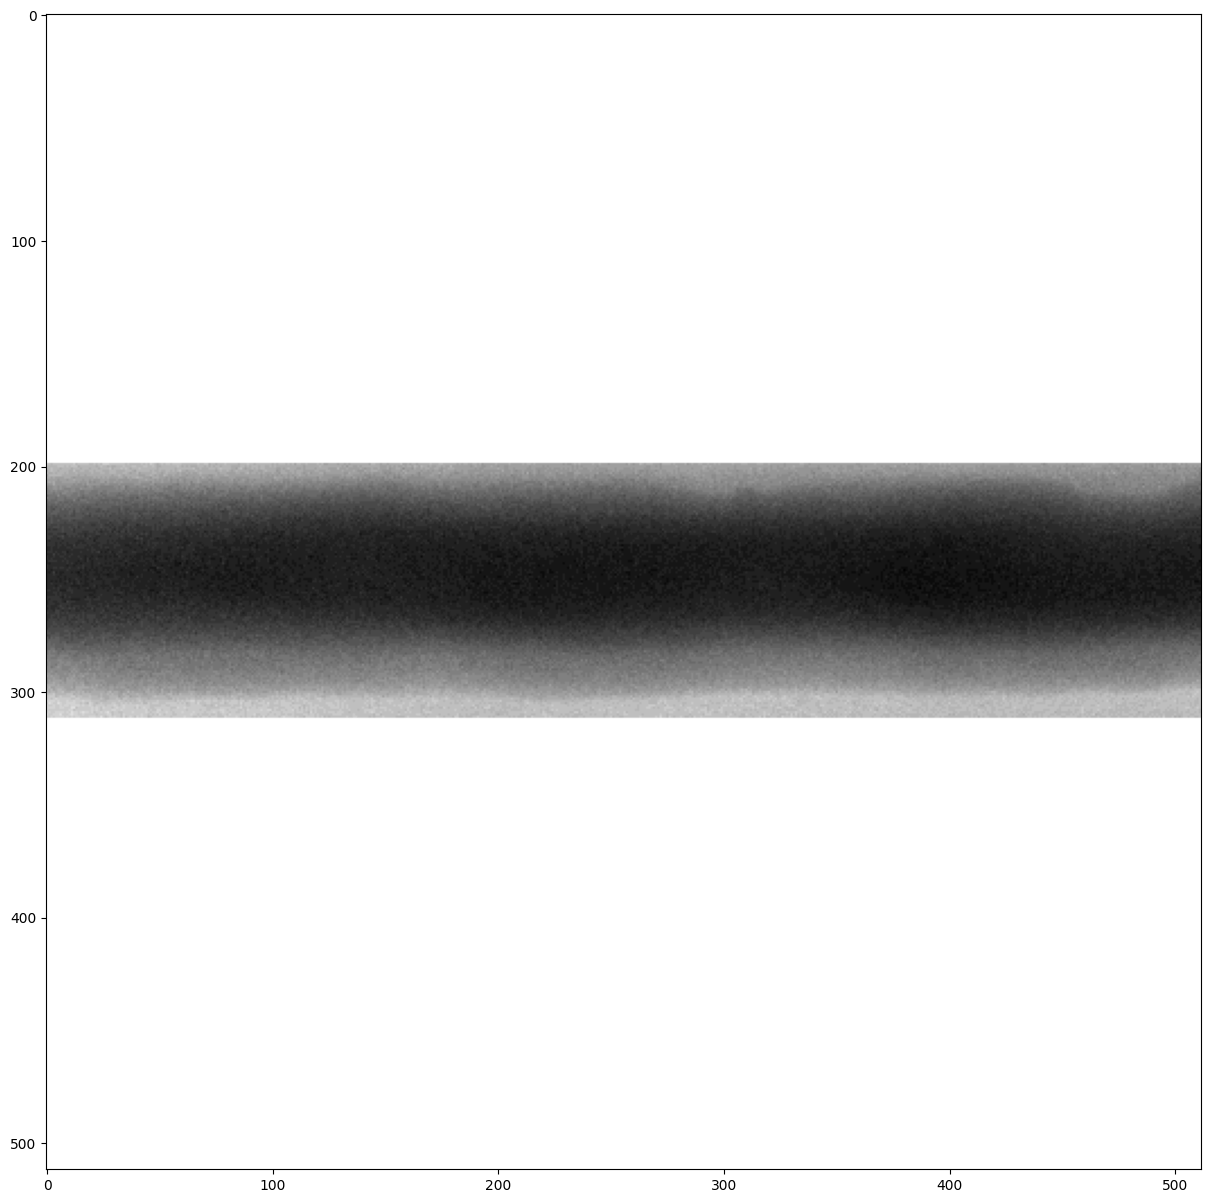

In [5]:
img_0 = test_image_list[-2]
plt.figure(figsize=(15, 15))
plt.imshow(img_0, cmap='gray')
img_0 = np.expand_dims(img_0, axis=0)
print(img_0.shape)

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 512, 512, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 510, 510, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      184

<Figure size 1500x1500 with 0 Axes>

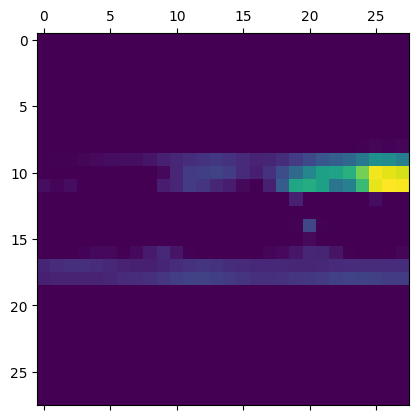

In [38]:
model = tf.keras.models.load_model("/app/models/CNN.h5")

grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.layers[-3].output, model.output]
)
grad_model.summary()


preds = model.predict(img_0)
print("Predicted:", preds)

heatmap = make_gradcam_heatmap(img_0, model, "conv2d_4")

# Display heatmap
plt.figure(figsize=(15, 15))
plt.matshow(heatmap)
plt.show()

In [34]:
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.01):
    # Load the original image
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.colormaps.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

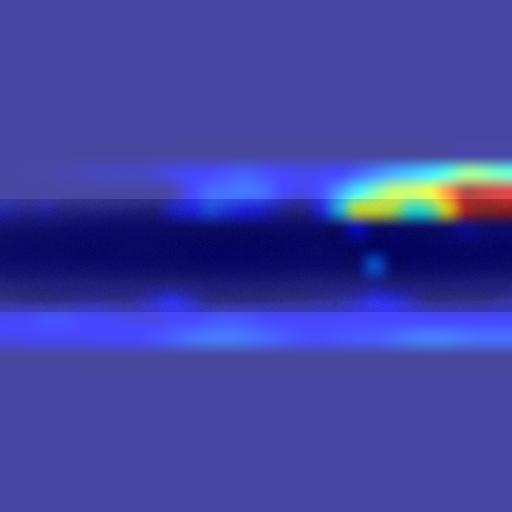

In [35]:
save_and_display_gradcam(test_image_list[-2], heatmap)